<a href="https://colab.research.google.com/github/SvetlanaTsim/ml_in_business/blob/main/lesson_04/HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Задача uplift-моделирования

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

In [124]:
!wget 'https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ' -O data.csv

--2022-12-24 11:14:35--  https://drive.google.com/uc?id=1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ
Resolving drive.google.com (drive.google.com)... 142.250.1.113, 142.250.1.101, 142.250.1.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.1.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0jbno3750r9gs8gsvhc27vo1e9t92fc1/1671880425000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ?uuid=ed21fc90-f5b3-4d51-8e48-cd6325762e9a [following]
--2022-12-24 11:14:36--  https://doc-00-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0jbno3750r9gs8gsvhc27vo1e9t92fc1/1671880425000/14904333240138417226/*/1a47_w6J2G2k_IQNCaPX5JO56-4qfM1pJ?uuid=ed21fc90-f5b3-4d51-8e48-cd6325762e9a
Resolving doc-00-c0-docs.googleusercontent.com (doc-00-c0-docs.googleusercontent.com)... 142.251.6.132, 2607:f8b0:4001:c5a::84
Connecting to doc-00-c0-d

In [125]:
!pip install scikit-uplift catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [126]:
import numpy as np 
import pandas as pd 

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from sklift.viz import plot_qini_curve
from sklift.viz import plot_uplift_curve
from sklift.models import ClassTransformation
from sklift.models import TwoModels

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [127]:
df = pd.read_csv('data.csv')
df.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

             offer  conversion  
0  Buy One Get One           0  
1         No Offer           0  
2  Buy One Get One           0  
3         Discount           0  
4  Buy One Get One           0

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   recency        64000 non-null  int64  
 1   history        64000 non-null  float64
 2   used_discount  64000 non-null  int64  
 3   used_bogo      64000 non-null  int64  
 4   zip_code       64000 non-null  object 
 5   is_referral    64000 non-null  int64  
 6   channel        64000 non-null  object 
 7   offer          64000 non-null  object 
 8   conversion     64000 non-null  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [129]:
df['offer'].value_counts()

Buy One Get One    21387
Discount           21307
No Offer           21306
Name: offer, dtype: int64

In [130]:
df.rename(columns = {'conversion': 'target', 'offer':'treatment'}, inplace = True )
df.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

         treatment  target  
0  Buy One Get One       0  
1         No Offer       0  
2  Buy One Get One       0  
3         Discount       0  
4  Buy One Get One       0

In [131]:
df = df.replace({'treatment' : { 'No Offer' : 0, 'Buy One Get One' : 1, 'Discount' : 1}})
df['treatment'].value_counts()

1    42694
0    21306
Name: treatment, dtype: int64

In [132]:
df.head()

recency  history  used_discount  used_bogo   zip_code  is_referral channel  \
0       10   142.44              1          0  Surburban            0   Phone   
1        6   329.08              1          1      Rural            1     Web   
2        7   180.65              0          1  Surburban            1     Web   
3        9   675.83              1          0      Rural            1     Web   
4        2    45.34              1          0      Urban            0     Web   

   treatment  target  
0          1       0  
1          0       0  
2          1       0  
3          1       0  
4          1       0

In [133]:
df['channel'].value_counts()

Web             28217
Phone           28021
Multichannel     7762
Name: channel, dtype: int64

In [134]:
df['zip_code'].value_counts()

Surburban    28776
Urban        25661
Rural         9563
Name: zip_code, dtype: int64

3. сделать разбиение набора данных не тренировочную и тестовую выборки

In [135]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='target'),
                                                    df['target'],
                                                    test_size=0.25,  
                                                    random_state=123,
                                                    stratify=df['target'])

treat_train = X_train['treatment']
X_train.drop(columns=['treatment'], inplace=True)
treat_test = X_test['treatment']
X_test.drop(columns='treatment', inplace=True)

4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [136]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]


from sklearn.preprocessing import StandardScaler


continuos_cols = ['recency', 'history']
cat_cols = ['zip_code', 'channel']
base_cols = ['used_discount', 'used_bogo', 'is_referral']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

In [137]:
#посмотрим списки

continuos_transformers+cat_transformers+base_transformers

[('recency', Pipeline(steps=[('selector', NumberSelector(key='recency')),
                  ('standard', StandardScaler())])),
 ('history', Pipeline(steps=[('selector', NumberSelector(key='history')),
                  ('standard', StandardScaler())])),
 ('zip_code', Pipeline(steps=[('selector', ColumnSelector(key='zip_code')),
                  ('ohe', OHEEncoder(key='zip_code'))])),
 ('channel', Pipeline(steps=[('selector', ColumnSelector(key='channel')),
                  ('ohe', OHEEncoder(key='channel'))])),
 ('used_discount',
  Pipeline(steps=[('selector', NumberSelector(key='used_discount'))])),
 ('used_bogo',
  Pipeline(steps=[('selector', NumberSelector(key='used_bogo'))])),
 ('is_referral',
  Pipeline(steps=[('selector', NumberSelector(key='is_referral'))]))]

In [138]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

X_train_tree = X_train.copy()

X_train = feature_processing.fit_transform(X_train)

In [139]:
X_test = feature_processing.transform(X_test)

In [140]:
X_train

array([[ 0.63939677,  1.77246431,  0.        , ...,  0.        ,
         1.        ,  1.        ],
       [ 0.92487096, -0.37229909,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.63939677, -0.48391186,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 0.35392258,  0.15663986,  0.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 1.21034515, -0.23785556,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.21034515, -0.82606069,  0.        , ...,  0.        ,
         1.        ,  1.        ]])

5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

In [141]:
metrics_df = pd.DataFrame(columns=['model', 'uplift@10%', 'uplift@20%'])
metrics_df

Empty DataFrame
Columns: [model, uplift@10%, uplift@20%]
Index: []

## 1. Подход с одной моделью

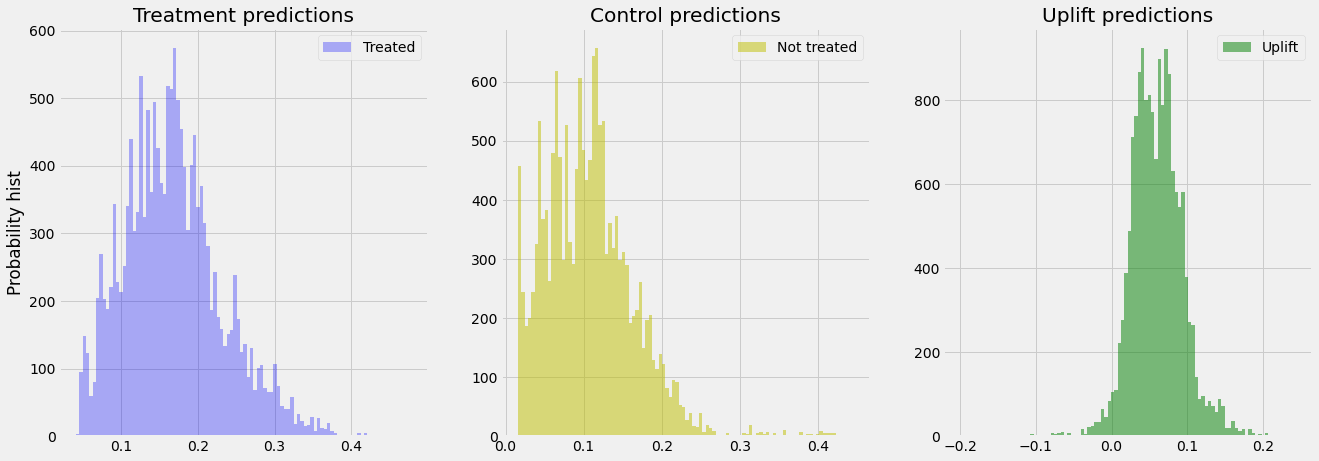

In [142]:
sm = SoloModel(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=[]))

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(sm).__name__,
    'uplift@10%': sm_score_10,
    'uplift@20%': sm_score_20
}, ignore_index=True)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [143]:
metrics_df

model  uplift@10%  uplift@20%
0  SoloModel    0.061914    0.051265

### 1.2 Трансформация классов

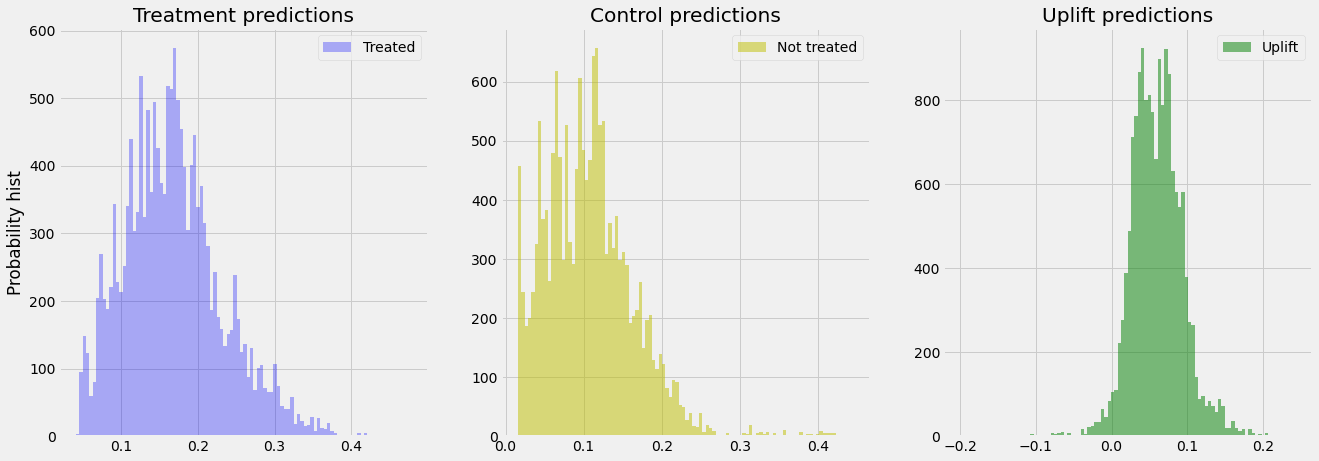

In [144]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=[]))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(ct).__name__,
    'uplift@10%': ct_score_10,
    'uplift@20%': ct_score_20
}, ignore_index=True)


# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm.trmnt_preds_, ctrl_preds=sm.ctrl_preds_);

In [145]:
metrics_df


model  uplift@10%  uplift@20%
0            SoloModel    0.061914    0.051265
1  ClassTransformation    0.064728    0.061123

### 2. Две независимые модели

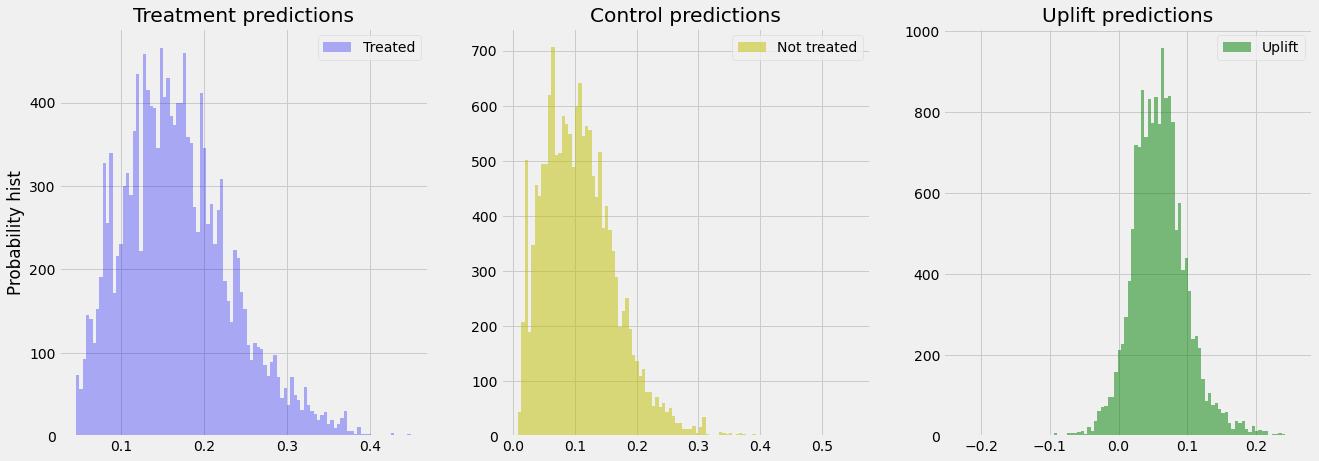

In [146]:
tm = TwoModels(
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=[]),
    CatBoostClassifier(iterations=20, random_state=42, silent=True, cat_features=[]),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

metrics_df = metrics_df.append({
    'model': type(tm).__name__,
    'uplift@10%': tm_score_10,
    'uplift@20%': tm_score_20
}, ignore_index=True)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [147]:
metrics_df

model  uplift@10%  uplift@20%
0            SoloModel    0.061914    0.051265
1  ClassTransformation    0.064728    0.061123
2            TwoModels    0.062852    0.062515

**Выводы**

При uplift@10% лучший результат показала модель ClassTransformation	

При uplift@20% лучший результат показала модель TwoModels	

7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево

In [148]:
!git clone https://github.com/uber/causalml.git
!cd causalml
!pip install -r requirements.txt
!pip install causalml

fatal: destination path 'causalml' already exists and is not an empty directory.
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [149]:
X_train_tree

recency  history  used_discount  used_bogo   zip_code  is_referral  \
29416        8   694.68              0          1  Surburban            1   
5754         9   146.06              1          0  Surburban            0   
60654        8   117.51              1          0  Surburban            0   
47546        6   280.50              1          0  Surburban            1   
40044        3   156.96              1          0  Surburban            0   
...        ...      ...            ...        ...        ...          ...   
10955        1   161.13              0          1      Urban            1   
35785        3    29.99              0          1      Rural            0   
50172        7   281.36              1          1  Surburban            1   
50529       10   180.45              0          1      Urban            0   
61406       10    29.99              0          1      Urban            1   

            channel  
29416  Multichannel  
5754            Web  
60654           Web  
47546         Phone  
40044         Phone  
...             ...  
10955           Web  
35785           Web  
50172         Phone  
50529           Web  
61406           Web  

[48000 rows x 7 columns]

In [ ]:
X_train_tree = pd.concat([X_train_tree.drop('zip_code', 1), 
                          pd.get_dummies(X_train_tree['zip_code'], prefix='zip_code')], 1)

X_train_tree = pd.concat([X_train_tree.drop('channel', 1), 
                          pd.get_dummies(X_train_tree['channel'], prefix='channel')], 1)

features = [col for col in X_train_tree]

In [151]:
X_train_tree.head()

recency  history  used_discount  used_bogo  is_referral  \
29416        8   694.68              0          1            1   
5754         9   146.06              1          0            0   
60654        8   117.51              1          0            0   
47546        6   280.50              1          0            1   
40044        3   156.96              1          0            0   

       zip_code_Rural  zip_code_Surburban  zip_code_Urban  \
29416               0                   1               0   
5754                0                   1               0   
60654               0                   1               0   
47546               0                   1               0   
40044               0                   1               0   

       channel_Multichannel  channel_Phone  channel_Web  
29416                     1              0            0  
5754                      0              0            1  
60654                     0              0            1  
47546                     0              1            0  
40044                     0              1            0

CPU times: user 4.22 s, sys: 94.9 ms, total: 4.32 s
Wall time: 7.1 s


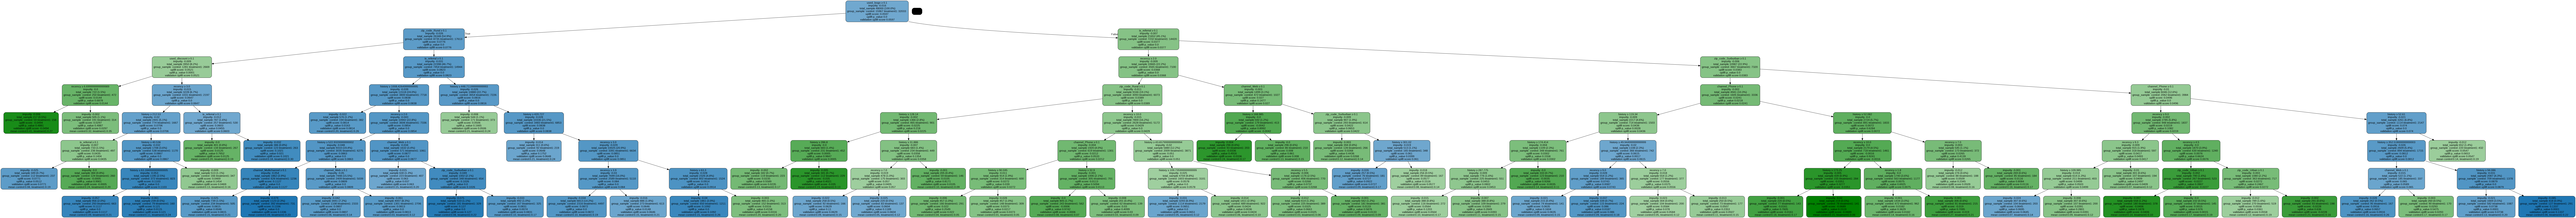

In [153]:
%%time
from IPython.display import Image
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.tree import uplift_tree_string, uplift_tree_plot

uplift_model = UpliftTreeClassifier(max_depth=8, min_samples_leaf=200, min_samples_treatment=50,
                                    n_reg=100, evaluationFunction='KL', control_name='control')

uplift_model.fit(X_train_tree,
                 treatment=treat_train.map({1: 'treatment1', 0: 'control'}).values,
                 y=y_train)

graph = uplift_tree_plot(uplift_model.fitted_uplift_tree, features)
Image(graph.create_png())

**Попытаемся объяснить полученную схему**

Каждый блок показывает значение uplift для этой группы объектов. Значение p-value(вероятность того, что это статитически достоверно). По мере спуска вниз данные разделяются на основе критерия Джинни, полученного по расстоянию Кульбака-Лейбница.Данные можно посмотреть по любому уровню разбиения. В каждом блоке указан признак и его значение, которое приводит к данному разбиению. Например, в корневом узле происходит разбиение по критерию призанаки used_bogo > 1. Дальше идет рабиение по критерию zip_code_Rural >0.1, потом по is_refferal > 0.1 и так далее.  